In [82]:
#disable warnings
import warnings
warnings.filterwarnings('ignore')

In [83]:
# import libs
import sklearn.linear_model as L
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
import pandas as P
import numpy as N
import re as R
from scipy.stats import pointbiserialr

In [84]:
import matplotlib.pyplot as PP
import seaborn as S

PP.style.use('seaborn-dark')

In [85]:
# helpers
o = lambda f: lambda g: lambda x: f(g(x))
fit = lambda X: lambda Y:  L.LinearRegression().fit(X, Y)
predict = lambda X: lambda R: R.predict(X)
RMSE = lambda Y: lambda P: mean_squared_error(Y, P, squared=False)
get_dummies = lambda X: P.get_dummies(X, drop_first=True)
drop_column = lambda c: lambda X: X.drop(c, axis=1)
split_sample = lambda X, **kwargs1: lambda Y, **kwargs2: train_test_split(X, Y, **{ 'test_size': 0.2, 'random_state': 42, **kwargs1, **kwargs2 })

def predictofit (S, **kwargs):
    X_train, X_test, Y_train, Y_test = S
    return predict(X_test)(fit(X_train)(Y_train))
def show_RMSE (X, Y, **kwargs):
    S = split_sample(X)(Y, **kwargs)
    X_train, X_test ,Y_train, Y_test = S
    print('RMSE: ', RMSE(Y_test)(predictofit(S, **kwargs)))

def tableIO (file):
    table = P.read_csv(file)
    table = table.dropna()
    X = table.drop(['median_house_value'], axis=1)
    Y = table['median_house_value']
    def initialXY():
        return (X.copy(), Y.copy())
    return (table.copy(), initialXY)

In [86]:
# initialize environment
table, initialXY = tableIO('housing.csv')

X, Y = initialXY()

In [87]:
table.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [88]:
# structure description
print('(rows, columns):', table.shape, '\n')
print('tipo dos dados:\n\n', table.dtypes, '\n' )
print('valores da coluna com valores categoricos "ocean_proximity"', table['ocean_proximity'].unique(), '\n')

(rows, columns): (20433, 10) 

tipo dos dados:

 longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object 

valores da coluna com valores categoricos "ocean_proximity" ['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND'] 



In [89]:
# median house value mean groupped by ocean proximity
ocean_proximity_group = table.groupby(['ocean_proximity'])
house_value_mean_by_ocean_proximity = [(k, op['median_house_value'].mean()) for k,op in ocean_proximity_group]

for t in house_value_mean_by_ocean_proximity:
    print(t[0], '\n house value mean: ', t[1], '\n')

<1H OCEAN 
 house value mean:  240267.99081248615 

INLAND 
 house value mean:  124896.86314655172 

ISLAND 
 house value mean:  380440.0 

NEAR BAY 
 house value mean:  259279.29207048457 

NEAR OCEAN 
 house value mean:  249042.35502283106 



In [90]:
# continuous data correlation with median house value
numeric_columns = table.select_dtypes(['float64', 'int64'])
corr = numeric_columns.loc[:, numeric_columns.columns != 'median_house_value'].corrwith(numeric_columns['median_house_value'])
print(corr.sort_values())

latitude             -0.144638
longitude            -0.045398
population           -0.025300
total_bedrooms        0.049686
households            0.064894
housing_median_age    0.106432
total_rooms           0.133294
median_income         0.688355
dtype: float64


In [91]:
# correlation with dummies
_X, _Y = initialXY()
_X = get_dummies(_X)
_X.corrwith(_Y)

longitude                    -0.045398
latitude                     -0.144638
housing_median_age            0.106432
total_rooms                   0.133294
total_bedrooms                0.049686
population                   -0.025300
households                    0.064894
median_income                 0.688355
ocean_proximity_INLAND       -0.484787
ocean_proximity_ISLAND        0.023525
ocean_proximity_NEAR BAY      0.160526
ocean_proximity_NEAR OCEAN    0.140378
dtype: float64

In [92]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY


In [93]:
Y.head()

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64

In [94]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100


In [95]:
Y.describe()

count     20433.000000
mean     206864.413155
std      115435.667099
min       14999.000000
25%      119500.000000
50%      179700.000000
75%      264700.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [96]:
# RMSE with every column
_X, _Y = initialXY()
_X = get_dummies(_X)
show_RMSE(_X, _Y)


RMSE:  69297.7166911303


In [97]:
# RMSE but ocean_proximity
_X, _Y = initialXY()
_X = drop_column(['ocean_proximity'])(_X)
show_RMSE(_X, _Y)

RMSE:  70156.120457364


In [98]:
# RMSE: inland

_X, _Y = initialXY()
_X['inland'] = get_dummies(_X)['ocean_proximity_INLAND']
_X = drop_column(['ocean_proximity'])(_X)

show_RMSE(_X, _Y)

RMSE:  69214.20460374332


In [99]:
# RMSE: inverse inland

_X, _Y = initialXY()
_X['inland'] = N.invert(get_dummies(_X)['ocean_proximity_INLAND'])
_X = drop_column(['ocean_proximity'])(_X)

show_RMSE(_X, _Y)

RMSE:  69214.20460374338


In [100]:
_X, _Y = initialXY()
_X = get_dummies(_X)
show_RMSE(_X, _Y, random_state=42)

RMSE:  69297.7166911303


In [101]:
# pointbiserialr
_X, _Y = initialXY()
_X = get_dummies(_X[['ocean_proximity']])

for col in _X.filter(regex="^ocean_proximity"):
    print(col, ':')
    print(pointbiserialr(_X[col], _Y))
    print()


ocean_proximity_INLAND :
PointbiserialrResult(correlation=-0.4847869526471506, pvalue=0.0)

ocean_proximity_ISLAND :
PointbiserialrResult(correlation=0.023525091989054323, pvalue=0.0007709157772743374)

ocean_proximity_NEAR BAY :
PointbiserialrResult(correlation=0.16052561205165197, pvalue=5.235348535917847e-118)

ocean_proximity_NEAR OCEAN :
PointbiserialrResult(correlation=0.14037755885592818, pvalue=1.9944193422294368e-90)



In [102]:
X, Y = initialXY()
X = X[['median_income']]
show_RMSE(X, Y)


RMSE:  84976.53325615863


<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

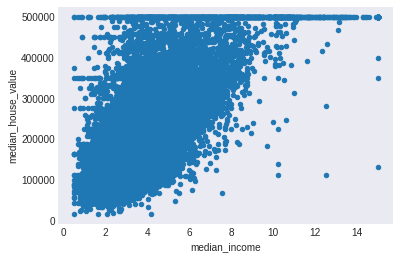

In [103]:
from sklearn.preprocessing import MinMaxScaler

X, Y = initialXY()
X = get_dummies(X)
clmns = X.columns 
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)
X = P.DataFrame(X, columns=clmns)

table.plot.scatter("median_income", "median_house_value")

<module 'pandas' from '/nix/store/3a6ardk55mlcynrs7hn4l4vynbm6wp7w-python3-3.9.10-env/lib/python3.9/site-packages/pandas/__init__.py'>

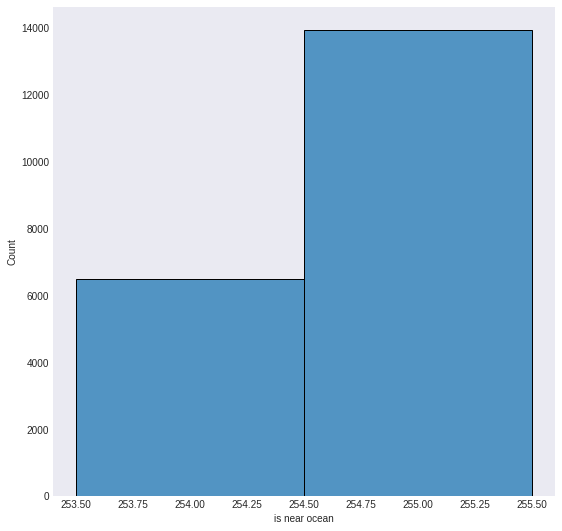

In [104]:
PP.figure(figsize=(9, 9))

X, Y = initialXY()
X = get_dummies(X)
S.histplot(x=N.invert(X['ocean_proximity_INLAND']), discrete=True ).set_xlabel('is near ocean')
display(P)

<module 'pandas' from '/nix/store/3a6ardk55mlcynrs7hn4l4vynbm6wp7w-python3-3.9.10-env/lib/python3.9/site-packages/pandas/__init__.py'>

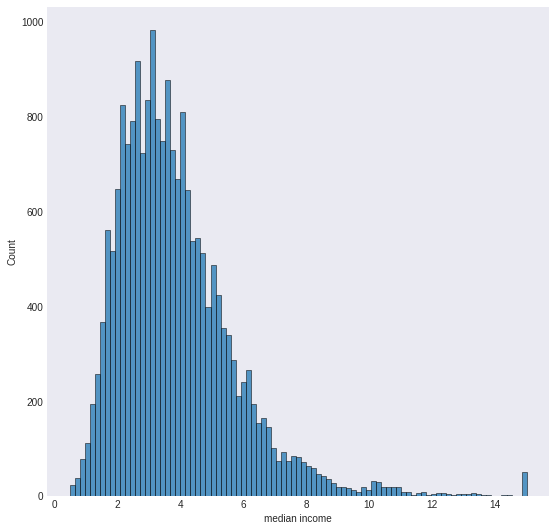

In [105]:

PP.figure(figsize=(9, 9))

X, Y = initialXY()
S.histplot(x=X['median_income']).set_xlabel('median income')
display(P)

<AxesSubplot:xlabel='median_income'>

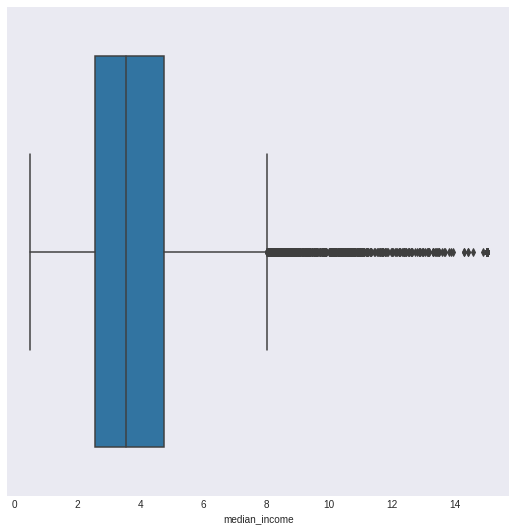

In [106]:
PP.figure(figsize=(9, 9))

X, Y = initialXY()
S.boxplot(x=X['median_income'])

<Figure size 648x648 with 0 Axes>

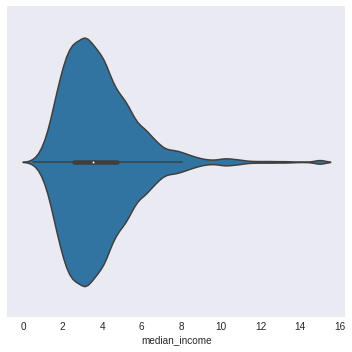

In [107]:
p = PP.figure(figsize=(9, 9))
X, Y = initialXY()
T = X
T['median_house_value'] = Y

S.catplot(x="median_income", kind="violin", data=T)

In [108]:
p = PP.figure(figsize=(9, 9))

T = table.copy()
# T = get_dummies(T)
# T = P.DataFrame(MinMaxScaler().fit_transform(T), columns=T.columns)
_T = drop_column(['ocean_proximity'])(T)
_T = P.DataFrame(MinMaxScaler().fit_transform(_T), columns=_T.columns)
_T['ocean_proximity'] = T['ocean_proximity']
_T.sample(10)
# S.catplot(x="median_income", y='median_house_value', hue='ocean_proximity', data=_T)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2688,0.858566,0.027630,0.843137,0.011954,0.012415,0.005690,0.009209,0.117819,0.162476,INLAND
19898,0.409363,0.575983,0.647059,0.044382,0.061142,0.026122,0.059365,0.077592,0.132785,INLAND
2033,0.460159,0.445271,0.117647,0.062541,0.100248,0.044396,0.090446,0.062123,0.432990,INLAND
10813,0.644422,0.126461,0.627451,0.058218,0.092024,0.090501,0.096695,0.186466,0.306186,<1H OCEAN
15655,0.190239,0.554729,1.000000,0.053614,0.070298,0.022787,0.071863,0.235031,0.731958,NEAR BAY
7271,0.617530,0.150903,0.627451,0.030495,0.052607,0.041453,0.054761,0.136702,0.278351,<1H OCEAN
16435,0.304781,0.550478,0.411765,0.041406,0.062539,0.123294,0.058707,0.102019,0.098971,INLAND
15846,0.187251,0.552604,1.000000,0.039066,0.047176,0.022871,0.052294,0.247217,0.656907,NEAR BAY
1188,0.268924,0.723698,0.450980,0.025459,0.038796,0.030690,0.037165,0.086571,0.147218,INLAND
13198,0.667331,0.161530,0.784314,0.029732,0.051676,0.041369,0.054761,0.120695,0.155672,INLAND


<Figure size 648x648 with 0 Axes>

In [109]:
X, Y = initialXY()
X = get_dummies(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
f = fit(X_train)(Y_train)
p = predict(X_test)(f)
X.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,0.317917,0.000245,0.111095,0.128615
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,0.465678,0.015641,0.314257,0.334782
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.000000,0.000000,0.000000,0.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,0.000000,0.000000,0.000000,0.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,1.000000,1.000000,1.000000,1.000000


array([[<AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'longitude'}>],
       [<AxesSubplot:title={'center':'latitude'}>, <AxesSubplot:>]],
      dtype=object)

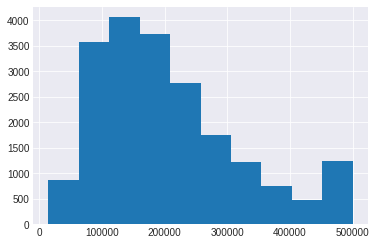

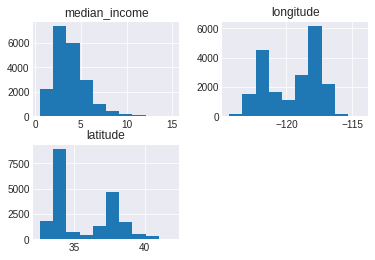

In [110]:
# %%

X, Y = initialXY()
# X = drop_column(['ocean_proximity', 'latitude', 'longitude'])(X)
Y.hist()
# for k in X:
#     X[[k]].hist()
X[['median_income', 'longitude', 'latitude']].hist()

In [111]:
# correlação
numeric_columns = table.select_dtypes(['float64', 'int64'])
corr = numeric_columns.loc[:, numeric_columns.columns != 'median_house_value'].corrwith(numeric_columns['median_house_value'])
print(corr.sort_values())

latitude             -0.144638
longitude            -0.045398
population           -0.025300
total_bedrooms        0.049686
households            0.064894
housing_median_age    0.106432
total_rooms           0.133294
median_income         0.688355
dtype: float64


In [112]:
X, Y = initialXY()
X = P.get_dummies(X, drop_first=True)
X_train, X_test, Y_train, Y_test = split_sample(X)(Y)

L.LinearRegression().fit(X_train, Y_train).score(X_test, Y_test)

0.6488402154431994

In [114]:
def remove_outliers (T, col):
    t = T.copy()
    c = T[col]
    t = t.dropna()
    Q3 = N.percentile(c, 75)
    Q2 = N.percentile(c, 25)
    IQR = Q3 - Q2

    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q2 - 1.5 * IQR
    upper, = N.where(c >= upper_bound)
    lower, = N.where(c <  lower_bound)

    t.drop(t[t[col] >= upper_bound ].index, inplace=True)
    t.drop(t[t[col] < lower_bound].index, inplace=True)

    return t

X, Y = initialXY()
T = X
T['median_house_value'] = Y
print(T.shape)

T = reduce(remove_outliers, T.select_dtypes(['float64', 'int64']).columns , T)
# S.boxplot(T['median_house_value'])
T = get_dummies(T)
X = drop_column(['median_house_value'])(T)
Y = T['median_house_value']

print('shape:', X.shape, Y.shape)

X_train, X_test, Y_train, Y_test = split_sample(X)(Y)

mean_squared_error( Y_test , L.LinearRegression().fit(X_train, Y_train).predict(X_test))

(20433, 10)
shape: (16719, 12) (16719,)


3081381525.730274

In [ ]:
def plot_

/nix/store/3a6ardk55mlcynrs7hn4l4vynbm6wp7w-python3-3.9.10-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nix/store/3a6ardk55mlcynrs7hn4l4vynbm6wp7w-python3-3.9.10-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nix/store/3a6ardk55mlcynrs7hn4l4vynbm6wp7w-python3-3.9.10-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version

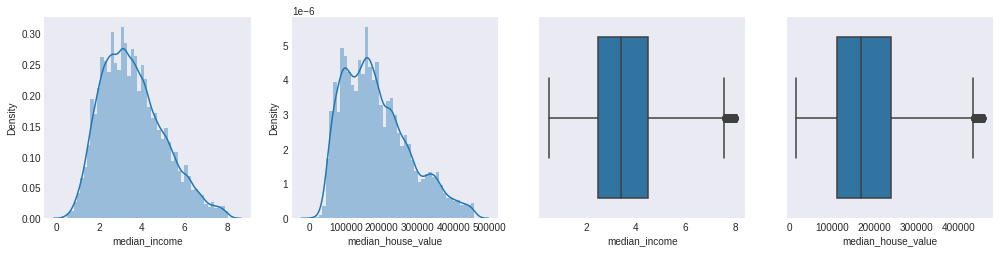

In [ ]:
PP.figure(figsize=(17,17))
PP.subplot(4,4,1)
S.distplot(T['median_income'])
PP.subplot(4,4,2)
S.distplot(T['median_house_value'])
PP.subplot(4,4,3)
S.boxplot(T['median_income'])
PP.subplot(4,4,4)
S.boxplot(T['median_house_value'])
PP.show()

/nix/store/3a6ardk55mlcynrs7hn4l4vynbm6wp7w-python3-3.9.10-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nix/store/3a6ardk55mlcynrs7hn4l4vynbm6wp7w-python3-3.9.10-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nix/store/3a6ardk55mlcynrs7hn4l4vynbm6wp7w-python3-3.9.10-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version

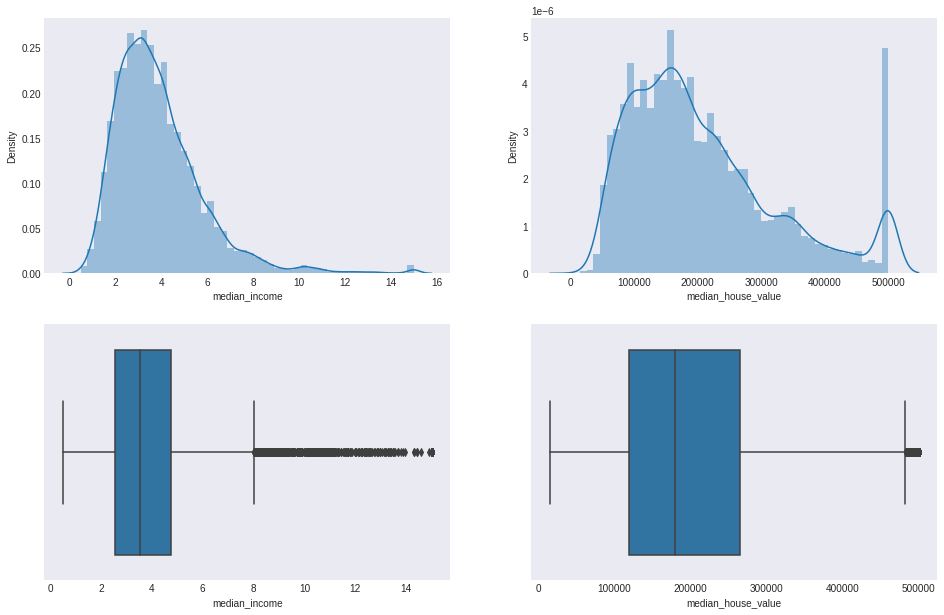

In [ ]:
T = table.copy()
PP.figure(figsize=(16,16))
PP.subplot(3,2,1)
S.distplot(T['median_income'])
PP.subplot(3,2,2)
S.distplot(T['median_house_value'])
PP.subplot(3,2,3)
S.boxplot(T['median_income'])
PP.subplot(3,2,4)
S.boxplot(T['median_house_value'])
PP.show()

119600.0 264725.0
bounds:  482412.5 -98087.5
BEFORE
shape: 0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64
max 500001.0
min 14999.0
AFTER 0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64
shape: 0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64
max 500001.0
min 14999.0


/nix/store/3a6ardk55mlcynrs7hn4l4vynbm6wp7w-python3-3.9.10-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0

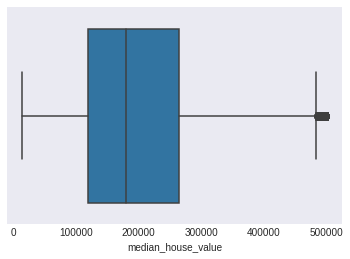

In [ ]:
T = table.copy()
median_income = T['median_house_value'].copy()
Q3 = N.percentile(median_income, 75)
Q2 = N.percentile(median_income, 25)
print(Q2, Q3)
IQR = Q3 - Q2

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q2 - 1.5 * IQR

print('bounds: ', upper_bound, lower_bound)

upper, = N.where(median_income >= upper_bound)
lower, = N.where(median_income <  lower_bound)

print('BEFORE')
print("shape:", median_income)
print("max", median_income.max())
print("min", median_income.min())
# median_income.drop(upper, inplace = True)
# median_income.drop(lower, inplace = True)

T['median_house_value'] = median_income.drop(upper)
T['median_house_value']  = T['median_house_value'].fillna(upper_bound)


T['median_house_value'] = median_income.drop(lower)
T['median_house_value']  = T['median_house_value'].fillna(lower_bound)

print("AFTER", median_income)
print("shape:", median_income)
print("max", median_income.max())
print("min", median_income.min())

S.boxplot(median_income)
N.isnan(T['median_house_value']).sum()


In [ ]:
print(upper)
P.DataFrame(upper)

[   89   140   459 ... 20427 20436 20443]


,0
0,89
1,140
2,459
3,489
4,493
...,...
1066,20422
1067,20426
1068,20427
1069,20436


/nix/store/3a6ardk55mlcynrs7hn4l4vynbm6wp7w-python3-3.9.10-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nix/store/3a6ardk55mlcynrs7hn4l4vynbm6wp7w-python3-3.9.10-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


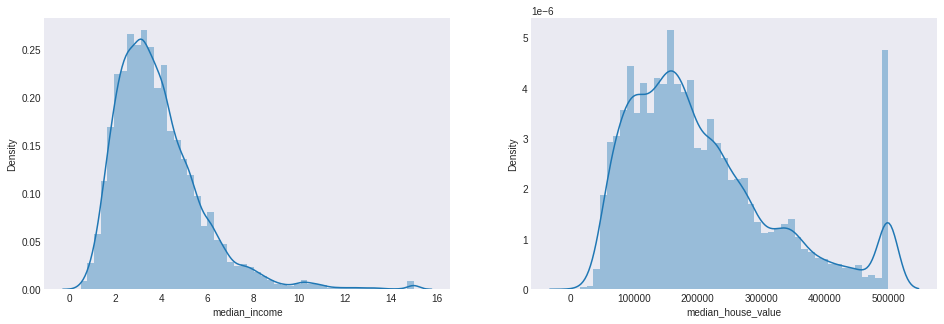

In [ ]:
PP.figure(figsize=(16,5))
PP.subplot(1,2,1)
S.distplot(T['median_income'])
PP.subplot(1,2,2)
S.distplot(T['median_house_value'])
PP.show()

/nix/store/3a6ardk55mlcynrs7hn4l4vynbm6wp7w-python3-3.9.10-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/nix/store/3a6ardk55mlcynrs7hn4l4vynbm6wp7w-python3-3.9.10-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


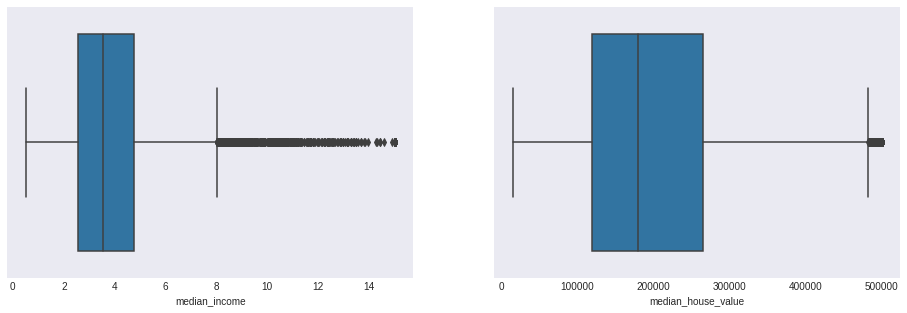

In [ ]:
PP.figure(figsize=(16,5))
PP.subplot(1,2,1)
S.boxplot(T['median_income'])
PP.subplot(1,2,2)
S.boxplot(T['median_house_value'])
PP.show()
